<a href="https://colab.research.google.com/github/shivam-kotwalia/data-science-project/blob/master/Interpretability_CNN_Grad_CAM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras as keras
import cv2
from PIL import Image
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
vgg16 = keras.applications.VGG16()

225214464/225209952 [==============================] - 3s 0us/step


In [0]:
image_path = keras.utils.get_file("lion.jpg", "http://www.krugerpark.co.za/images/black-maned-lion-shem-compion-590x390.jpg")

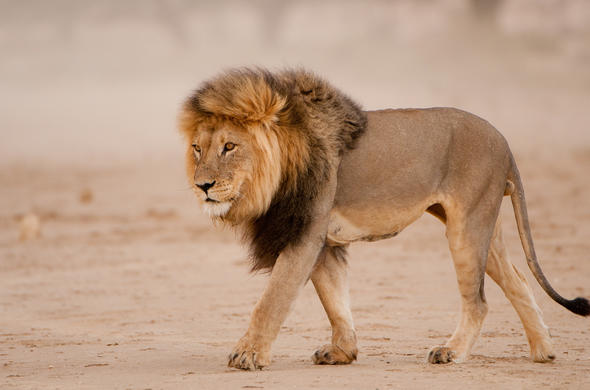

In [18]:
keras.preprocessing.image.load_img(image_path)

In [0]:
def get_processed_image(image_path):
    image = keras.preprocessing.image.load_img(image_path)
    image = keras.preprocessing.image.img_to_array(image)
    image = cv2.resize(image, (224, 224))
    image = keras.applications.vgg16.preprocess_input(image)
    image = np.expand_dims(image, axis=0)
    return image

In [0]:
image = get_processed_image(image_path)

In [33]:
image.shape, image.max(), image.min() # already normalized no need for rescale 1/255.0

((1, 224, 224, 3), 116.00799, -118.42544)

In [34]:
keras.applications.vgg16.decode_predictions(vgg16.predict(image))[0][0][1]

'lion'

In [0]:
# Make one model with multiple output
output_layers = [layer.output for layer in vgg16.layers[1:18]]

In [41]:
#creating a new model with output_layers as Output
vis_model = keras.Model(vgg16.input, output_layers)
vis_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
output_layer_names = []   # Saving OUTPUT LAYERS name in a list
for layer in output_layers:
    output_layer_names.append(layer.name.split("/")[0])

In [95]:
vis_model.input_shape, vis_model.output_shape

((None, 224, 224, 3),
 [(None, 224, 224, 64),
  (None, 224, 224, 64),
  (None, 112, 112, 64),
  (None, 112, 112, 128),
  (None, 112, 112, 128),
  (None, 56, 56, 128),
  (None, 56, 56, 256),
  (None, 56, 56, 256),
  (None, 56, 56, 256),
  (None, 28, 28, 256),
  (None, 28, 28, 512),
  (None, 28, 28, 512),
  (None, 28, 28, 512),
  (None, 14, 14, 512),
  (None, 14, 14, 512),
  (None, 14, 14, 512),
  (None, 14, 14, 512)])

In [0]:
vis_model_result = vis_model.predict(image)

In [49]:
len(vis_model_result) #Results from all the 17 layers have been returned 

17

In [50]:
vis_model_result[-1].shape # As we know the last CONV layer returns 7,7,512

(1, 14, 14, 512)

In [0]:
def output_layers_plot(layer_number, row=5, col=8, figsize=(15, 12)):
    filters = vis_model_result[layer_number].shape[3]
    if row*col > filters:
        return f"{filters} filters are less than {row*col} plots"
    plt.figure(figsize=figsize)
    for i in range(1, row*col):
        plt.subplot(row, col,i)
        activation = np.squeeze(vis_model_result[layer_number])[:, :, i]
        # Normalize the activaton 
        activation -= activation.mean()
        activation /= activation.std()
        # Make it a image & clip values in range 
        activation *= 255
        activation = np.clip(activation, 0, 255).astype(np.uint8)
        plt.imshow(activation)

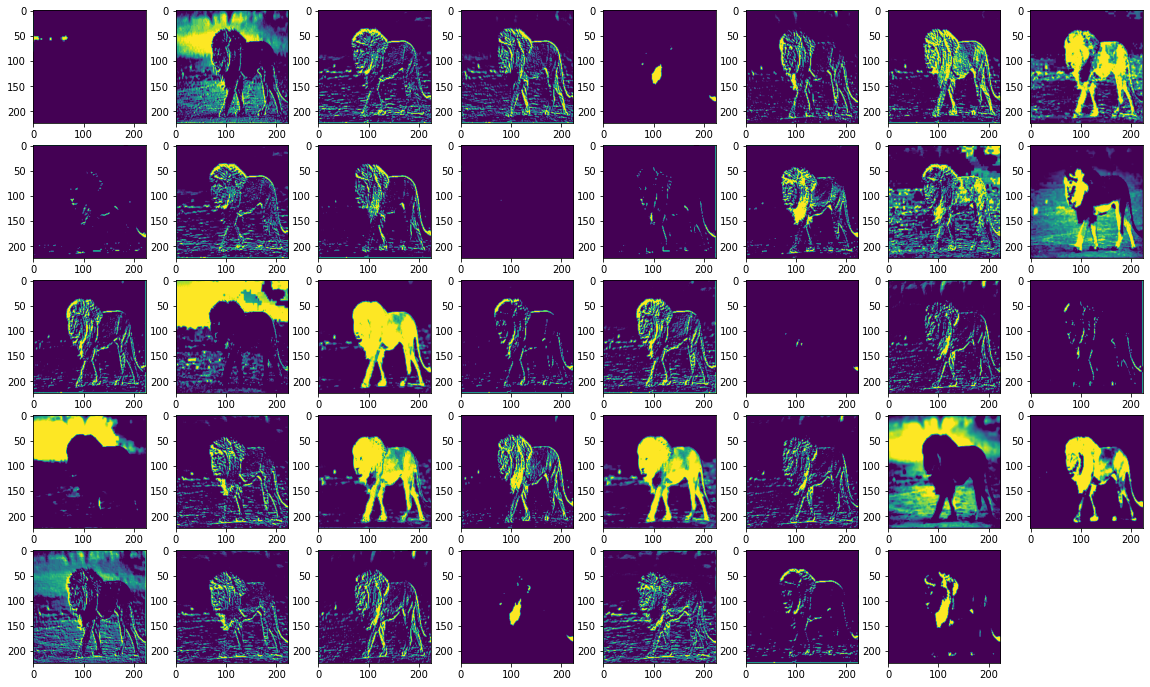

In [99]:
output_layers_plot(0, figsize=(20, 12))

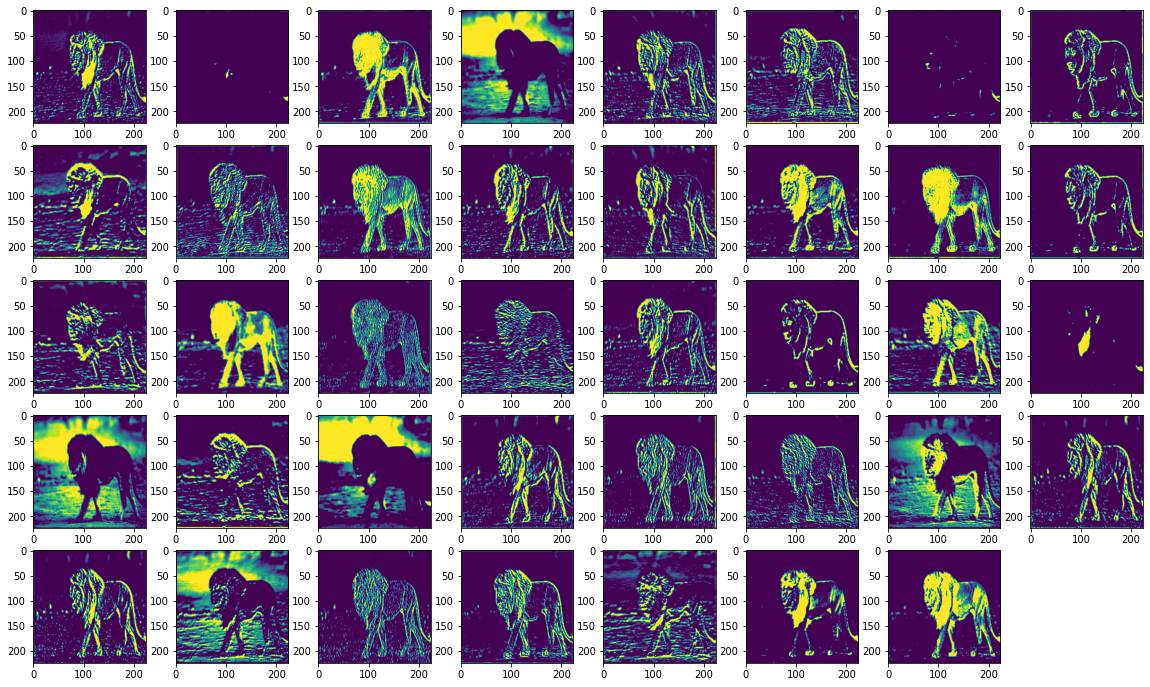

In [88]:
output_layers_plot(1, figsize=(20, 12))

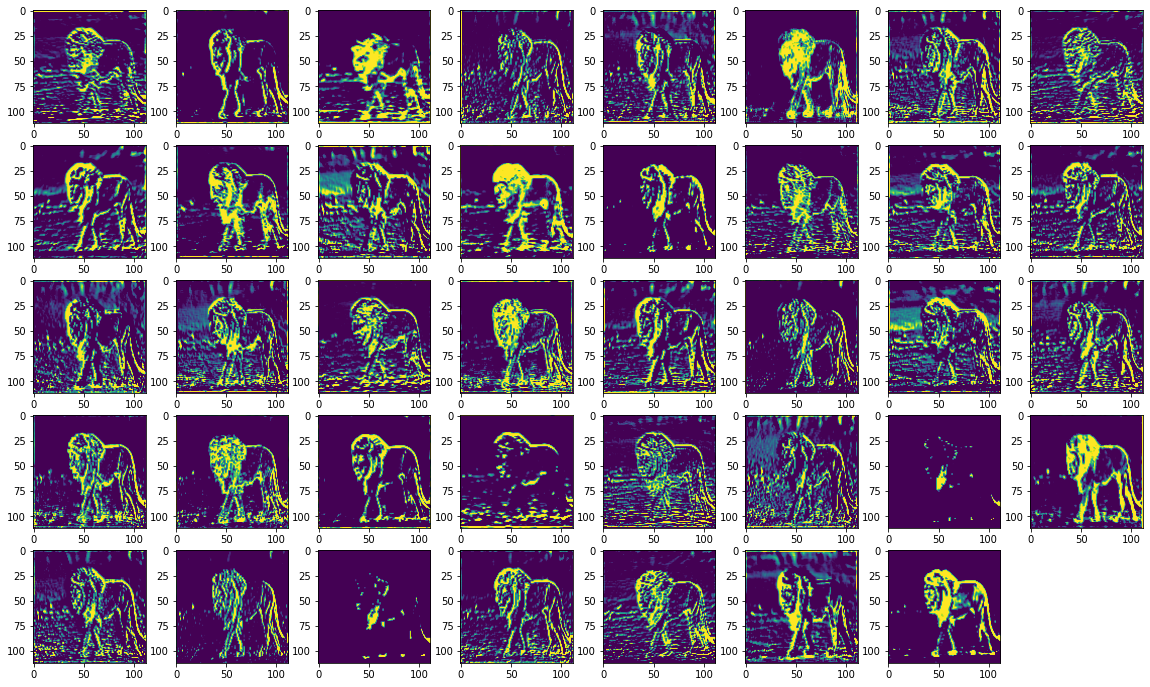

In [89]:
output_layers_plot(3, figsize=(20, 12))

In [0]:
# Grad CAM 

In [0]:
def grad_cam_superimposed_image(image_path, layer=7): # as we want gradient from last conv - block5_conv3 
    grad_model = keras.Model([vgg16.input], [vgg16.layers[-7].output, vgg16.output])
    
    # grad_model.output
    # [<tf.Tensor 'block5_conv2_1/Identity:0' shape=(None, 14, 14, 512) dtype=float32>,
    # <tf.Tensor 'predictions_2/Identity:0' shape=(None, 1000) dtype=float32>]

    with tf.GradientTape() as tape:
        layer_result, prediction = grad_model(get_processed_image(image_path))
        loss = prediction[:, np.argmax(prediction)]    
    ############################################################################
    # layer_result.shape, vis_model_result[-2].shape, type(layer_result.numpy()), type(vis_model_result[-2])
    # # (TensorShape([1, 14, 14, 512]), (1, 14, 14, 512), numpy.ndarray, numpy.ndarray)

    # (layer_result.numpy() == vis_model_result[-2]).all()  
    # # True
    ############################################################################

    grad_valus = tape.gradient(loss, layer_result)  # Calculating the gradient
    # grad_valus.shape TensorShape([1, 14, 14, 512])# Grad values at last conv w.r.t the loss incurred for the image
    grad_valus = keras.backend.mean(grad_valus, axis=(0,1,2))   # took mean across dimentions to get one value per filter
    grad_valus = grad_valus.numpy()
    
    #Converting layer result in numpy and sqeezing 
    layer_result = np.squeeze(layer_result.numpy())

    # mutliply each gradiend to its corresponding filter 
    for i in range(grad_valus.shape[0]):
        layer_result[:, :, i] *= grad_valus[i]
    
    heatmap = np.mean(layer_result, axis=-1)
    # heatmap.shape (14, 14) # This represents the heatmap for 7 layer all filters
    heatmap = np.maximum(heatmap, 0) # removing negative entries
    # normalize
    heatmap /= heatmap.max()
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


    heatmap_resized = cv2.resize(heatmap, (224, 224))
    # 0.5 here is a heatmap intensity factor
    super_imposed_image = heatmap_resized * 0.5 + cv2.resize(keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(image_path)), (224, 224))
    super_imposed_image = np.clip(super_imposed_image, 0,255).astype(np.uint8)
    return super_imposed_image

In [0]:
grad_cam_image = grad_cam_superimposed_image(image_path)

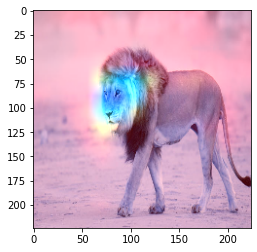

In [205]:
plt.imshow(grad_cam_image)

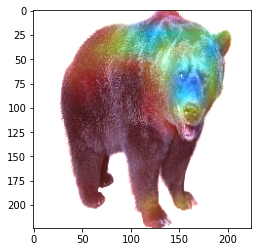

In [213]:
plt.imshow(grad_cam_superimposed_image(keras.utils.get_file("bear.png", 
                                                            "https://www.nationalgeographic.com/content/dam/animals/pictures/mammals/g/grizzly-bear/grizzly-bear_01.adapt.1900.1.JPG")))

245760/243249 [==============================] - 0s 0us/step


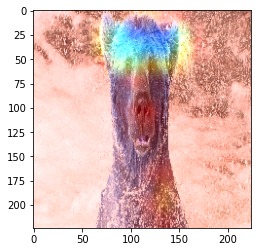

In [214]:
#https://c402277.ssl.cf1.rackcdn.com/photos/16934/images/hero_full/Medium_WW266637.jpg
plt.imshow(grad_cam_superimposed_image(keras.utils.get_file("bear2.png", 
                                                            "https://c402277.ssl.cf1.rackcdn.com/photos/16934/images/hero_full/Medium_WW266637.jpg")))

40960/35916 [==================================] - 0s 5us/step


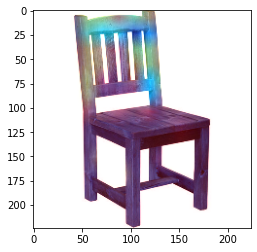

In [215]:
#https://5.imimg.com/data5/DQ/XK/MY-56039866/wooden-chair-500x500.jpg
plt.imshow(grad_cam_superimposed_image(keras.utils.get_file("chair.png", 
                                                            "https://5.imimg.com/data5/DQ/XK/MY-56039866/wooden-chair-500x500.jpg")))